In [198]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [199]:
df=pd.read_csv("Transactions.csv",index_col=0,parse_dates=['instance_date'],date_format='%Y-%m-%d')
##drop all Arabic columns

strings_to_drop=['_ar','_parties']
df = df.drop(columns=[col for col in df.columns if any(s in col for s in strings_to_drop)])

df.sample(5)

print(df.columns)


Index(['procedure_id', 'trans_group_id', 'trans_group_en', 'procedure_name_en',
       'instance_date', 'property_type_id', 'property_type_en',
       'property_sub_type_id', 'property_sub_type_en', 'property_usage_en',
       'reg_type_id', 'reg_type_en', 'area_id', 'area_name_en',
       'building_name_en', 'project_number', 'project_name_en',
       'master_project_en', 'nearest_landmark_en', 'nearest_metro_en',
       'nearest_mall_en', 'rooms_en', 'has_parking', 'actual_worth',
       'meter_sale_price', 'rent_value', 'meter_rent_price'],
      dtype='object')


In [200]:
df_sales=df.loc[df['trans_group_en']=="Sales"]

# fig=sns.barplot(data=df_sales,y='meter_sale_price',x='property_type_en',hue='property_type_en')
# fig.set_ybound(0,30000)

df_sales.describe()


,procedure_id,trans_group_id,property_type_id,property_sub_type_id,reg_type_id,area_id,project_number,has_parking,actual_worth,meter_sale_price,rent_value,meter_rent_price
count,1.037063e+06,1037063.0,1.037063e+06,867422.000000,1.037063e+06,1.037063e+06,779320.000000,1.037063e+06,1.037063e+06,1.037063e+06,0.0,0.0
mean,6.091127e+01,1.0,2.981676e+00,54.734135,5.910094e-01,4.167141e+02,1675.652388,6.914469e-01,2.630317e+06,1.482616e+04,NaN,NaN
std,7.059950e+01,0.0,6.948681e-01,20.126921,4.916478e-01,6.799981e+01,850.747818,4.618964e-01,1.211181e+07,1.174738e+05,NaN,NaN
min,4.000000e+00,1.0,1.000000e+00,2.000000,0.000000e+00,2.290000e+02,2.000000,0.000000e+00,1.000000e+00,0.000000e+00,NaN,NaN
25%,1.100000e+01,1.0,3.000000e+00,60.000000,0.000000e+00,3.500000e+02,1130.000000,0.000000e+00,7.150000e+05,7.829005e+03,NaN,NaN
50%,4.100000e+01,1.0,3.000000e+00,60.000000,1.000000e+00,4.350000e+02,1740.000000,1.000000e+00,1.315000e+06,1.162791e+04,NaN,NaN
75%,1.020000e+02,1.0,3.000000e+00,60.000000,1.000000e+00,4.650000e+02,2330.000000,1.000000e+00,2.400888e+06,1.741467e+04,NaN,NaN
max,8.520000e+02,1.0,4.000000e+00,112.000000,1.000000e+00,5.310000e+02,3448.000000,1.000000e+00,3.869204e+09,8.125000e+07,NaN,NaN


when price/meter was analyzed, unit > building > Villa > land 

In [201]:
### do isolation forest to identify distress sales and over priced sales

In [202]:
isna_chk=df_sales.isna().sum()
# print(isna_chk.values)
isna_chk_df=pd.DataFrame({'col_name':isna_chk.index,'isna_count':isna_chk.values})
nancols=isna_chk_df.loc[isna_chk_df['isna_count']>0]['col_name'].to_list()
df_sales=df_sales.dropna(how='all')
# print(nancols)

# print(df_sales.shape)
# 2. Remove obvious outliers using IQR method:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25) 
    Q3 = df[column].quantile(0.75) 
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR 
    upper_bound = Q3 + 1.5 * IQR 
    return df[(df[column] >= lower_bound) & (df[column]
                                            <= upper_bound)]
df_sales_num=df_sales.select_dtypes(include=['float64','int64'])

print(df_sales_num.shape)



df_sales_cat=df_sales.select_dtypes(include=['object'])

# for col in df_sales_num.columns:
#     df_sales_num=remove_outliers(df_sales,col)
# print(df_sales_num.shape)

# df_sales=pd.concat([df_sales_num,df_sales_cat],axis=1)

# print(df_sales.shape)




(1037063, 12)


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest 
from sklearn.compose import ColumnTransformer

numeric_features=df_sales_num.columns.to_list()
categorical_features=df_sales_cat.columns.to_list()

df_sales=pd.concat([df_sales.head(20000),df_sales.tail(20000)],ignore_index=True)

StandardScaler = StandardScaler()
encoder = OneHotEncoder()

df_sales_num_scaled=pd.DataFrame(StandardScaler.fit_transform(df_sales_num),columns=numeric_features)
#df_sales_cat_encoded=pd.DataFrame(OneHotEncoder.fit_transform(df_sales_cat).toarray(),columns=categorical_features)
df_sales_cat_encoded = pd.DataFrame(encoder.fit_transform(df_sales_cat[categorical_features]).toarray(), columns=categorical_features)
df_sales_cat_encoded.describe()
df_sales_num_scaled.describe()

df_sales_num.head(5)
# Use Isolation Forest 



In [204]:

from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.ensemble import IsolationForest 
from sklearn.compose import ColumnTransformer



# Identify numeric and categorical columns
numeric_features = df_sales.select_dtypes(include=['float64', 'int64']).columns
categorical_features = df_sales.select_dtypes(include=['object']).columns

# df_sales_mini=pd.concat([df_sales.head(20000),df_sales.tail(20000)],ignore_index=True)

# df_sales=df_sales_mini.copy()

# Initialize StandardScaler and OneHotEncoder
scaler = StandardScaler()
encoder = OneHotEncoder()

# Apply StandardScaler to numerical features
df_sales_num_scaled = pd.DataFrame(scaler.fit_transform(df_sales[numeric_features]), columns=numeric_features)

# Apply OneHotEncoder to categorical features
#df_sales_cat_encoded = pd.DataFrame(encoder.fit_transform(df_sales[categorical_features]).toarray(), columns=encoder.get_feature_names_out(categorical_features))

# Check the resulting scaled and encoded data
# print(df_sales_num_scaled.describe())
# print(df_sales_cat_encoded.describe())

# Combine the scaled numerical and encoded categorical features
# df_processed = pd.concat([df_sales_num_scaled, df_sales_cat_encoded], axis=1)

df_processed=df_sales_num_scaled.copy()
df_processed.sample(5)




c:\Users\ccb\OneDrive\Desktop\tensorflow\DubaiRealEstateProject\my_venv\lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\ccb\OneDrive\Desktop\tensorflow\DubaiRealEstateProject\my_venv\lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\ccb\OneDrive\Desktop\tensorflow\DubaiRealEstateProject\my_venv\lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


,procedure_id,trans_group_id,property_type_id,property_sub_type_id,reg_type_id,area_id,project_number,has_parking,actual_worth,meter_sale_price,rent_value,meter_rent_price
371019,0.581998,0.0,0.02637,-0.632692,-1.202100,-0.981094,-0.818871,0.668014,-0.167697,-0.041225,NaN,NaN
224541,0.581998,0.0,0.02637,0.261633,-1.202100,0.445382,-0.092451,0.668014,0.000873,0.029045,NaN,NaN
8959,0.581998,0.0,0.02637,0.261633,-1.202100,-0.172267,1.649547,0.668014,-0.072333,0.103778,NaN,NaN
742902,-0.706964,0.0,0.02637,0.261633,0.831878,-1.275212,NaN,0.668014,-0.138816,-0.094179,NaN,NaN
438572,0.581998,0.0,0.02637,0.261633,-1.202100,-0.392856,0.164970,0.668014,0.282343,0.176613,NaN,NaN


In [205]:
# Use Isolation Forest
iforest=IsolationForest(contamination=0.01)
iforest.fit(df_processed)
# outliers=iforest.predict(df_processed)
# print(df_processed[outliers==-1].head(10))

df_processed['anomaly_score'] = iforest.fit_predict(df_processed)



In [243]:
anomalies=(df_processed.loc[df_processed['anomaly_score']==-1])
print("size of anomaly data",anomalies.shape)
anomalies.to_csv('anomalies.csv')
anomalies_unscaled = pd.DataFrame(scaler.inverse_transform(anomalies.drop(columns=['anomaly_score'])), columns=numeric_features)
anomalies_unscaled.shape
anomalies_unscaled.columns

size of anomaly data (10369, 13)


Index(['procedure_id', 'trans_group_id', 'property_type_id',
       'property_sub_type_id', 'reg_type_id', 'area_id', 'project_number',
       'has_parking', 'actual_worth', 'meter_sale_price', 'rent_value',
       'meter_rent_price'],
      dtype='object')

81911
distress_sales_date-size (7839, 12)
overpriced_sales_daat_size (125, 12)


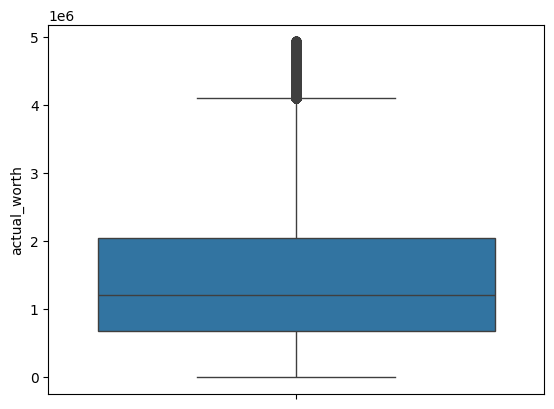

In [242]:
###plot distribution of actual_worth in actual dataset to see the distribution of sales and identify the median


df_sales_clean=remove_outliers(df_sales,'actual_worth')

print(abs(df_sales_clean.shape[0]-df_sales.shape[0]))


fig=sns.boxplot(data=df_sales_clean,y='actual_worth')

distress_threshold=df_sales_clean['actual_worth'].quantile(0.1)
overpriced_threshold=df_sales_clean['actual_worth'].quantile(0.9)
print("distress_sales_date-size",anomalies_unscaled.loc[anomalies_unscaled['actual_worth']>overpriced_threshold].shape)
print("overpriced_sales_daat_size",anomalies_unscaled.loc[anomalies_unscaled['actual_worth']<distress_threshold].shape)



